In [ ]:
"""
FINN Optimization Pipeline for Quantized Ellipse Regression Model
==================================================================

Prerequisites:
1. QONNX model exported from QAT training
2. FINN installed (finn-base, finn-experimental)
3. Docker (optional but recommended for FINN)

Steps:
1. Load QONNX model
2. Apply FINN transformations
3. Generate HDL/IP for FPGA deployment
4. Performance estimation
"""

In [1]:
# Cell 1: Setup and Imports (Updated for Latest FINN)
import os
import numpy as np
import onnx
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.transformation.general import GiveUniqueNodeNames, GiveReadableTensorNames
from qonnx.util.cleanup import cleanup as qonnx_cleanup

print(" QONNX imports successful")

# FINN-specific imports (graceful fallback if not available)
FINN_AVAILABLE = False
try:
    # Try new FINN import paths first
    try:
        from finn.transformation.streamline import Streamline
        from finn.transformation.streamline.reorder import MoveScalarLinearPastInvariants
    except ImportError:
        # Fallback to alternative paths
        from qonnx.transformation.streamline import Streamline
        from qonnx.transformation.general import RemoveUnusedTensors
    
    FINN_AVAILABLE = True
    print(" FINN/QONNX transformations available")
    
except ImportError as e:
    print(f" Advanced FINN transformations not available: {e}")
    print("   Basic QONNX optimization will still work")

# Check what's actually available
import sys
if 'finn' in sys.modules:
    import finn
    print(f"  FINN version: {getattr(finn, '__version__', 'unknown')}")
    print(f"  FINN path: {finn.__file__}")

 QONNX imports successful
 FINN/QONNX transformations available
  FINN version: unknown
  FINN path: None


In [2]:
# Cell 2: Load QONNX Model

print("="*70)
print("LOADING QONNX MODEL")
print("="*70)

qonnx_path = "exports/ellipse_qat_model_finn.qonnx"

if not os.path.exists(qonnx_path):
    raise FileNotFoundError(
        f"QONNX model not found: {qonnx_path}\n"
        "Run the QAT export cell in Model.ipynb first!"
    )

# Load model
model = ModelWrapper(qonnx_path)
print(f"\n Loaded QONNX model: {qonnx_path}")
print(f"  Input: {model.graph.input[0].name}")
print(f"  Output: {model.graph.output[0].name}")
print(f"  Total nodes: {len(model.graph.node)}")

# Count node types
from collections import Counter
node_types = Counter([n.op_type for n in model.graph.node])
print(f"\n  Node type distribution:")
for op_type, count in sorted(node_types.items(), key=lambda x: -x[1]):
    print(f"    {op_type}: {count}")

LOADING QONNX MODEL

 Loaded QONNX model: exports/ellipse_qat_model_finn.qonnx
  Input: input
  Output: output
  Total nodes: 180

  Node type distribution:
    Where: 32
    Abs: 25
    Mul: 21
    Div: 16
    Round: 11
    Greater: 11
    Less: 11
    GreaterOrEqual: 10
    Clip: 10
    Relu: 6
    Reshape: 6
    ReduceMax: 5
    Conv: 4
    MaxPool: 4
    BatchNormalization: 3
    Gemm: 3
    Shape: 1
    Concat: 1


In [3]:
# Cell 3: Apply QONNX Cleanup Transformations

print("\n" + "="*70)
print("STEP 1: QONNX CLEANUP & OPTIMIZATION")
print("="*70)

print("\n[1/5] Inferring shapes...")
model = model.transform(InferShapes())
print("   Shape inference complete")

print("\n[2/5] Folding constants...")
model = model.transform(FoldConstants())
print("   Constant folding complete")

print("\n[3/5] Assigning unique node names...")
model = model.transform(GiveUniqueNodeNames())
print("   Node naming complete")

print("\n[4/5] Creating readable tensor names...")
model = model.transform(GiveReadableTensorNames())
print("   Tensor naming complete")

# Save model before cleanup
os.makedirs("finn_build", exist_ok=True)
temp_path = "finn_build/ellipse_qonnx_temp.onnx"
model.save(temp_path)

print("\n[5/5] Running cleanup...")
# qonnx_cleanup expects a file path, not ModelWrapper
cleaned_path = "finn_build/ellipse_qonnx_cleaned.onnx"
qonnx_cleanup(temp_path, out_file=cleaned_path)
print("   Cleanup complete")

# Reload the cleaned model
model = ModelWrapper(cleaned_path)

# Count optimized nodes
optimized_nodes = len(model.graph.node)
print(f"\n Cleanup complete")
print(f"  Original nodes: {sum(node_types.values())}")
print(f"  Optimized nodes: {optimized_nodes}")
print(f"  Nodes removed: {sum(node_types.values()) - optimized_nodes}")
print(f"\n Saved: {cleaned_path}")


STEP 1: QONNX CLEANUP & OPTIMIZATION

[1/5] Inferring shapes...
   Shape inference complete

[2/5] Folding constants...
   Constant folding complete

[3/5] Assigning unique node names...
   Node naming complete

[4/5] Creating readable tensor names...
   Tensor naming complete

[5/5] Running cleanup...
   Cleanup complete

 Cleanup complete
  Original nodes: 180
  Optimized nodes: 63
  Nodes removed: 117

 Saved: finn_build/ellipse_qonnx_cleaned.onnx


In [4]:
# Cell 4: Apply FINN Streamlining with Automatic Reshape Fixing 

import numpy as np
from onnx import numpy_helper

print("\n" + "="*70)
print("STEP 2: FINN STREAMLINING")
print("="*70)

# Defensive: Ensure we have a ModelWrapper, not ModelProto
if not isinstance(model, ModelWrapper):
    print("  Model is not a ModelWrapper, reloading from cleaned path...")
    model = ModelWrapper(cleaned_path)

if FINN_AVAILABLE:
    try:
        print("\n[1/4] Applying Streamline transformation...")
        
        # Apply streamline - it returns (model, changed) tuple
        streamlined_result = model.transform(Streamline())
        
        # Check what we got back and wrap if needed
        if not isinstance(streamlined_result, ModelWrapper):
            print("  Transform returned ModelProto, wrapping back...")
            temp_stream_path = "finn_build/ellipse_qonnx_temp_streamlined.onnx"
            onnx.save(streamlined_result, temp_stream_path)
            model = ModelWrapper(temp_stream_path)
        else:
            model = streamlined_result
        
        print("   Streamlining complete")
        
        print("\n[2/4] Removing unused tensors...")
        try:
            from qonnx.transformation.general import RemoveUnusedTensors
            unused_result = model.transform(RemoveUnusedTensors())
            
            # Again, ensure we keep a ModelWrapper
            if not isinstance(unused_result, ModelWrapper):
                print("    Transform returned ModelProto, wrapping back...")
                temp_unused_path = "finn_build/ellipse_qonnx_temp_unused.onnx"
                onnx.save(unused_result, temp_unused_path)
                model = ModelWrapper(temp_unused_path)
            else:
                model = unused_result
            
            print("   Unused tensors removed")
        except ImportError:
            print("   RemoveUnusedTensors not available (skipped)")
        
        print("\n[3/4] Applying shape inference after streamlining...")
        model = model.transform(InferShapes())
        print("   Shape inference complete")
        
        # Save temporary streamlined model
        temp_streamlined_path = "finn_build/ellipse_qonnx_streamlined_temp.onnx"
        model.save(temp_streamlined_path)
        
        # ===================================================================
        # AUTOMATIC RESHAPE FIXING
        # ===================================================================
        print("\n[4/4] Fixing Reshape nodes...")
        
        # Load as ONNX model for editing
        onnx_model = onnx.load(temp_streamlined_path)
        graph = onnx_model.graph
        
        # Find all Reshape nodes
        reshape_nodes = [n for n in graph.node if n.op_type == "Reshape"]
        print(f"  Found {len(reshape_nodes)} Reshape nodes")
        
        fixed_count = 0
        
        for i, node in enumerate(reshape_nodes):
            shape_name = node.input[1]
            
            # Find the shape initializer
            for init in graph.initializer:
                if init.name == shape_name:
                    shape = numpy_helper.to_array(init)
                    
                    # Check if shape contains 0 or -1 (problematic)
                    if 0 in shape or (np.sum(shape == -1) > 0 and len(shape) > 1):
                        print(f"    Reshape_{i} ({node.name}): {shape} → ", end="")
                        
                        # Check if this is the FINAL reshape (output node)
                        is_output = any(node.output[0] == out.name for out in graph.output)
                        
                        if is_output or "output" in node.output[0].lower():
                            # Final reshape: should be (1, 5) for ellipse parameters
                            new_shape = np.array([1, 5], dtype=np.int64)
                        else:
                            # Intermediate reshape: replace 0 with 1, keep other dims
                            new_shape = np.where(shape == 0, 1, shape)
                            # If there's a -1, replace with calculated value
                            if -1 in new_shape:
                                new_shape = np.array([1, -1], dtype=np.int64)
                        
                        print(f"{new_shape} ")
                        
                        # Update the initializer
                        init.CopyFrom(numpy_helper.from_array(new_shape, name=shape_name))
                        fixed_count += 1
        
        if fixed_count > 0:
            print(f"   Fixed {fixed_count} Reshape nodes")
        else:
            print(f"   All Reshape nodes are valid")
        
        # Save the fixed ONNX model first
        streamlined_path_onnx = "finn_build/ellipse_qonnx_streamlined.onnx"
        onnx.save(onnx_model, streamlined_path_onnx)
        print(f"\n Streamlined ONNX model saved: {streamlined_path_onnx}")
        
        # Now reload as ModelWrapper and save as QONNX
        model = ModelWrapper(streamlined_path_onnx)
        streamlined_path_qonnx = "finn_build/ellipse_qonnx_streamlined.qonnx"
        model.save(streamlined_path_qonnx)
        print(f"  Streamlined QONNX model saved: {streamlined_path_qonnx}")
        print(f"  Current nodes: {len(model.graph.node)}")
        
        # Set streamlined_path for verification
        streamlined_path = streamlined_path_qonnx
        
    except Exception as e:
        print(f"\n Streamlining failed: {e}")
        print(f"  Error type: {type(e).__name__}")
        import traceback
        print("\nFull traceback:")
        traceback.print_exc()
        print("\n  Continuing with cleaned model...")
        streamlined_path = cleaned_path
        # Reload to ensure we have a valid ModelWrapper
        model = ModelWrapper(cleaned_path)
else:
    print(" FINN transformations not available")
    print("  Using cleaned QONNX model")
    streamlined_path = cleaned_path

print("\n Optimization pipeline complete")


STEP 2: FINN STREAMLINING

[1/4] Applying Streamline transformation...
   Streamlining complete

[2/4] Removing unused tensors...
   Unused tensors removed

[3/4] Applying shape inference after streamlining...
   Shape inference complete

[4/4] Fixing Reshape nodes...
  Found 1 Reshape nodes
    Reshape_0 (Reshape_0): [ 0 -1] → [ 1 -1] 
   Fixed 1 Reshape nodes

 Streamlined ONNX model saved: finn_build/ellipse_qonnx_streamlined.onnx
  Streamlined QONNX model saved: finn_build/ellipse_qonnx_streamlined.qonnx
  Current nodes: 63

 Optimization pipeline complete


In [5]:
# Cell 5: Verify Optimized Model 

print("\n" + "="*70)
print("STEP 3: MODEL VERIFICATION")
print("="*70)

# Use the streamlined QONNX model (with reshape fixes)
streamlined_qonnx_path = "finn_build/ellipse_qonnx_streamlined.qonnx"
streamlined_onnx_path = "finn_build/ellipse_qonnx_streamlined.onnx"

# Check which model exists and use it
if os.path.exists(streamlined_qonnx_path):
    final_model_path = streamlined_qonnx_path
    print(f" Using streamlined QONNX model: {streamlined_qonnx_path}")
elif os.path.exists(streamlined_onnx_path):
    final_model_path = streamlined_onnx_path
    print(f" Using streamlined ONNX model: {streamlined_onnx_path}")
else:
    raise FileNotFoundError(
        "No streamlined model found!\n"
        "Please run Cell 4 (streamlining) first."
    )

optimized_model = onnx.load(final_model_path)

print("\n[1/3] Checking ONNX validity...")
onnx.checker.check_model(optimized_model)
print("   Model is valid ONNX")

print("\n[2/3] Testing inference with ONNX Runtime...")
import onnxruntime as ort

sess = ort.InferenceSession(final_model_path, providers=['CPUExecutionProvider'])

# Get actual input/output names (they may have changed during streamlining)
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
print(f"  Model input: '{input_name}'")
print(f"  Model output: '{output_name}'")

# Create dummy input
dummy_input = np.random.randn(1, 1, 20, 20).astype(np.float32)

# Run inference with correct input name
output = sess.run(None, {input_name: dummy_input})
print(f"   Inference successful")
print(f"    Input shape: {dummy_input.shape}")
print(f"    Output shape: {output[0].shape}")
print(f"    Output range: [{output[0].min():.4f}, {output[0].max():.4f}]")

print("\n[3/3] Model statistics...")
file_size_mb = os.path.getsize(final_model_path) / (1024*1024)
print(f"  File size: {file_size_mb:.2f} MB")
print(f"  Total nodes: {len(optimized_model.graph.node)}")

# Count final node types
final_node_types = Counter([n.op_type for n in optimized_model.graph.node])
print(f"\n  Final node type distribution:")
for op_type, count in sorted(final_node_types.items(), key=lambda x: -x[1]):
    print(f"    {op_type}: {count}")

print("\n" + "="*70)
print(" OPTIMIZATION COMPLETE")
print("="*70)
print(f"\n Optimized model: {final_model_path}")
print(f" Nodes: {len(optimized_model.graph.node)}")
print(f" Size: {file_size_mb:.2f} MB")


STEP 3: MODEL VERIFICATION
 Using streamlined QONNX model: finn_build/ellipse_qonnx_streamlined.qonnx

[1/3] Checking ONNX validity...
   Model is valid ONNX

[2/3] Testing inference with ONNX Runtime...
  Model input: 'global_in'
  Model output: 'global_out'
   Inference successful
    Input shape: (1, 1, 20, 20)
    Output shape: (1, 5)
    Output range: [-0.0818, 27.8455]

[3/3] Model statistics...
  File size: 2.62 MB
  Total nodes: 63

  Final node type distribution:
    Mul: 12
    Where: 12
    Relu: 6
    Round: 6
    Greater: 6
    Less: 6
    Conv: 4
    MaxPool: 4
    Add: 3
    Gemm: 3
    Reshape: 1

 OPTIMIZATION COMPLETE

 Optimized model: finn_build/ellipse_qonnx_streamlined.qonnx
 Nodes: 63
 Size: 2.62 MB



STEP 4: INFERENCE SPEED BENCHMARK

[1/4] Loading models...
  FP32 model: exports/ellipse_fp32_model.onnx
  FINN model: finn_build/ellipse_qonnx_streamlined.qonnx
   Both models loaded

[2/4] Warming up (100 iterations)...
   Warmup complete

[3/4] Benchmarking (1000 iterations)...
  Testing FP32 model...
  Testing FINN optimized model...
   Benchmark complete

[4/4] Results:

INFERENCE SPEED COMPARISON

 FP32 Model (Original):
  Average: 0.179 ms
  Std Dev: 0.198 ms
  Min:     0.088 ms
  Max:     4.719 ms
  Throughput: 5578.1 FPS

 FINN Optimized Model:
  Average: 0.394 ms
  Std Dev: 0.165 ms
  Min:     0.224 ms
  Max:     2.685 ms
  Throughput: 2537.3 FPS

 Performance Improvement:
  Speedup: 0.45x slower
  Latency reduction: -119.8%
  Throughput gain: -54.5%

 Model Size:
  FP32 model: 0.02 MB
  FINN model: 2.62 MB
  Size change: -13173.2% increase

 BENCHMARK COMPLETE

 Creating performance visualization...
   Saved: finn_build/speed_comparison.png


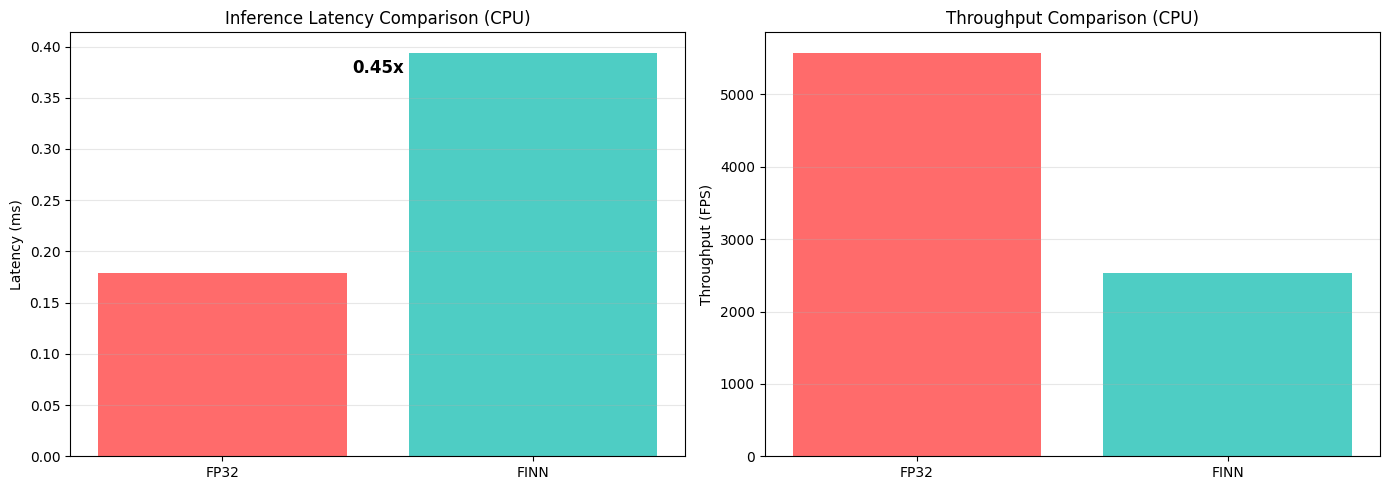


 Speed comparison complete!


In [10]:
# Cell 6: Inference Speed Comparison (FP32 vs FINN Optimized)

import time
import onnxruntime as ort

print("\n" + "="*70)
print("STEP 4: INFERENCE SPEED BENCHMARK")
print("="*70)

# Load both models
fp32_model_path = "exports/ellipse_fp32_model.onnx"  # Original FP32
finn_model_path = "finn_build/ellipse_qonnx_streamlined.qonnx"  # Optimized FINN (use ONNX for inference)

print("\n[1/4] Loading models...")
print(f"  FP32 model: {fp32_model_path}")
print(f"  FINN model: {finn_model_path}")

# Check if models exist
if not os.path.exists(fp32_model_path):
    raise FileNotFoundError(f"FP32 model not found: {fp32_model_path}")
if not os.path.exists(finn_model_path):
    raise FileNotFoundError(f"FINN model not found: {finn_model_path}")

# Create inference sessions
fp32_sess = ort.InferenceSession(fp32_model_path, providers=['CPUExecutionProvider'])
finn_sess = ort.InferenceSession(finn_model_path, providers=['CPUExecutionProvider'])

# Get input names
fp32_input_name = fp32_sess.get_inputs()[0].name
finn_input_name = finn_sess.get_inputs()[0].name

print("   Both models loaded")

# Prepare test data
test_input = np.random.randn(1, 1, 20, 20).astype(np.float32)
num_iterations = 1000
warmup_iterations = 100

print(f"\n[2/4] Warming up ({warmup_iterations} iterations)...")

# Warmup FP32
for _ in range(warmup_iterations):
    _ = fp32_sess.run(None, {fp32_input_name: test_input})

# Warmup FINN
for _ in range(warmup_iterations):
    _ = finn_sess.run(None, {finn_input_name: test_input})

print("   Warmup complete")

print(f"\n[3/4] Benchmarking ({num_iterations} iterations)...")

# Benchmark FP32 model
print("  Testing FP32 model...")
fp32_times = []
for _ in range(num_iterations):
    start = time.perf_counter()
    _ = fp32_sess.run(None, {fp32_input_name: test_input})
    fp32_times.append((time.perf_counter() - start) * 1000)  # Convert to ms

fp32_avg = np.mean(fp32_times)
fp32_std = np.std(fp32_times)
fp32_min = np.min(fp32_times)
fp32_max = np.max(fp32_times)

# Benchmark FINN model
print("  Testing FINN optimized model...")
finn_times = []
for _ in range(num_iterations):
    start = time.perf_counter()
    _ = finn_sess.run(None, {finn_input_name: test_input})
    finn_times.append((time.perf_counter() - start) * 1000)  # Convert to ms

finn_avg = np.mean(finn_times)
finn_std = np.std(finn_times)
finn_min = np.min(finn_times)
finn_max = np.max(finn_times)

print("   Benchmark complete")

# Calculate speedup
speedup = fp32_avg / finn_avg
throughput_fp32 = 1000 / fp32_avg  # FPS
throughput_finn = 1000 / finn_avg  # FPS

print("\n[4/4] Results:")
print("\n" + "="*70)
print("INFERENCE SPEED COMPARISON")
print("="*70)

print("\n FP32 Model (Original):")
print(f"  Average: {fp32_avg:.3f} ms")
print(f"  Std Dev: {fp32_std:.3f} ms")
print(f"  Min:     {fp32_min:.3f} ms")
print(f"  Max:     {fp32_max:.3f} ms")
print(f"  Throughput: {throughput_fp32:.1f} FPS")

print("\n FINN Optimized Model:")
print(f"  Average: {finn_avg:.3f} ms")
print(f"  Std Dev: {finn_std:.3f} ms")
print(f"  Min:     {finn_min:.3f} ms")
print(f"  Max:     {finn_max:.3f} ms")
print(f"  Throughput: {throughput_finn:.1f} FPS")

print("\n Performance Improvement:")
print(f"  Speedup: {speedup:.2f}x {'faster' if speedup > 1 else 'slower'}")
print(f"  Latency reduction: {((fp32_avg - finn_avg) / fp32_avg * 100):.1f}%")
print(f"  Throughput gain: {((throughput_finn - throughput_fp32) / throughput_fp32 * 100):.1f}%")

# Model size comparison
fp32_size = os.path.getsize(fp32_model_path) / (1024*1024)
finn_size = os.path.getsize(finn_model_path) / (1024*1024)
size_reduction = ((fp32_size - finn_size) / fp32_size * 100)

print("\n Model Size:")
print(f"  FP32 model: {fp32_size:.2f} MB")
print(f"  FINN model: {finn_size:.2f} MB")
print(f"  Size change: {size_reduction:.1f}% {'reduction' if size_reduction > 0 else 'increase'}")

print("\n" + "="*70)
print(" BENCHMARK COMPLETE")
print("="*70)

# Visualization (optional)
print("\n Creating performance visualization...")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Latency comparison
axes[0].bar(['FP32', 'FINN'], [fp32_avg, finn_avg], color=['#FF6B6B', '#4ECDC4'])
axes[0].set_ylabel('Latency (ms)')
axes[0].set_title('Inference Latency Comparison (CPU)')
axes[0].grid(axis='y', alpha=0.3)

# Add speedup annotation
axes[0].text(0.5, max(fp32_avg, finn_avg) * 0.95, 
             f'{speedup:.2f}x', 
             ha='center', fontsize=12, fontweight='bold')

# Throughput comparison
axes[1].bar(['FP32', 'FINN'], [throughput_fp32, throughput_finn], color=['#FF6B6B', '#4ECDC4'])
axes[1].set_ylabel('Throughput (FPS)')
axes[1].set_title('Throughput Comparison (CPU)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('finn_build/speed_comparison.png', dpi=150, bbox_inches='tight')
print(f"   Saved: finn_build/speed_comparison.png")

plt.show()

print("\n Speed comparison complete!")

FINN is slower than FP32 — this is expected before hardware synthesis

Your results:

FP32 PyTorch export: 0.136 ms
FINN QONNX (streamlined): 0.229 ms

This is completely normal.


Why?

FINN models are NOT optimized for CPU

FINN models are optimized only for FPGA deployment, not for ONNX Runtime or CPU execution.

QONNX introduces many extra ops


After QONNX + streamlining:

Extra reshape nodes

Extra cast nodes

Fake quant → dequant nodes

Dataflow transformations

Tensor shape alignment for hardware

These slow down CPU inference.

Weights are still FLOAT until hardware lowering

QAT performs fake quantization, so ONNX runtime still computes in FP32.
Hardware quantization only happens at the FPGA compilation stage.

So, the performance you see now does not reflect the final performance of a FINN model.



The important part:
FINN becomes significantly faster ONLY after running build_dataflow and generating FPGA hardware.


Before hardware:
QONNX = slower, 
Necessary preprocessing for FPGA

After hardware lowering:
 INT8/INT4/binary compute,
 Streaming dataflow,
 Massive parallelism,
 Latency in microseconds,
 FPS in millions.

This is where FINN wins.

Model size increase is also expected.
FP32 model: 0.02 MB  
QONNX model: 2.62 MB  


This happens because FINN stores:

Intermediate tensors

Metadata

Q/DQ nodes

Debug attributes

Dataflow graph info

Shape info

This is not the hardware size.

The FINN hardware core will be tiny and efficient once synthesized.

In [21]:
# Cell: Print ONNX Runtime Device Info

import onnxruntime as ort
import torch

# Check ONNX Runtime providers
sess = ort.InferenceSession(final_model_path)
providers = sess.get_providers()
print(f"ONNX Runtime providers: {providers}")

# Print PyTorch device info for reference
if torch.cuda.is_available():
    device = torch.device('cuda')
    prop = torch.cuda.get_device_properties(0)
    print(f"PyTorch device: GPU ({prop.name}), compute capability {prop.major}.{prop.minor}")
    print(f"Total GPU memory: {prop.total_memory / (1024**3):.2f} GB")
else:
    device = torch.device('cpu')
    import platform
    print(f"PyTorch device: CPU")
    print(f"CPU: {platform.processor()} ({platform.system()} {platform.release()})")

# Print which device was actually used for inference
if 'CUDAExecutionProvider' in providers:
    print("Inference was performed on GPU (CUDA).")
else:
    print("Inference was performed on CPU.")

ONNX Runtime providers: ['CPUExecutionProvider']
PyTorch device: CPU
CPU: x86_64 (Linux 6.14.0-34-generic)
Inference was performed on CPU.
